In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('No Cuda GPU detected.')

2.4.1
No Cuda GPU detected.


In [2]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 300])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [3]:
def plotPred (y_true, preds):
    ymin = np.min(y_true)
    ymax = np.max(y_true)
    plt.scatter(y_true, preds, label=f'score: {r2_score(y_true, preds)}')
    plt.plot([ymin, ymax], [ymin, ymax], '-.', color='red', label="predicted values = true values")
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.legend()

In [4]:
def buildAndCompile(shape):
    input = tf.keras.Input(shape=(shape,))
    output = layers.Dense(shape, activation='relu')(input)
    output = layers.Dense(64, activation='relu')(output)
    output = layers.Dense(1)(output)
    model = keras.Model(inputs=input, outputs=output)
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [5]:
rebuild = True
model = None

if rebuild:
    model = buildAndCompile(131)
else:
    model = keras.models.load_model('../model/')
    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 131)]             0         
_________________________________________________________________
dense (Dense)                (None, 131)               17292     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8448      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 25,805
Trainable params: 25,805
Non-trainable params: 0
_________________________________________________________________


(1000002, 131) (1000002,)
(1000002, 131) (1000002,)
CPU times: user 1h 26min 24s, sys: 15min 11s, total: 1h 41min 36s
Wall time: 42min 22s


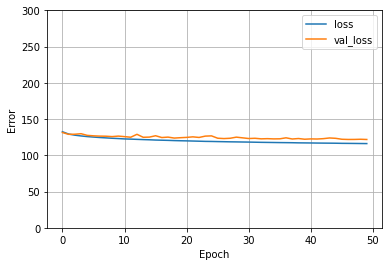

In [6]:
%%time
history = None
for i in range (2):
    dataframe_encoded = pd.read_csv('Datasets/dataset' + str(i+1) + '.csv')
    features = dataframe_encoded.columns[:-1]
    cps = dataframe_encoded.columns[-1]

    X = dataframe_encoded[features].values
    y = dataframe_encoded[cps].values
    print(X.shape, y.shape)
    
    history = model.fit(X, y, validation_split=0.1, verbose=0, epochs=50)

plot_loss(history)

In [8]:
test_df = pd.read_csv('Datasets/test_dataset.csv')
features = test_df.columns[:-1]
cps = test_df.columns[-1]

boards = test_df[features].values
scores = test_df[cps].values
print(boards.shape, scores.shape)
preds = model.predict(boards).flatten()

(200000, 131) (200000,)


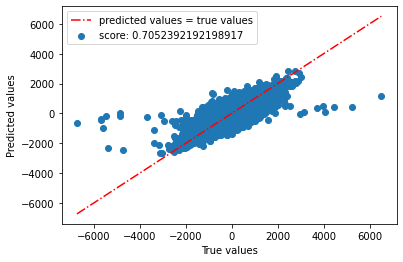

In [9]:
plotPred(scores, preds)

In [10]:
model = keras.models.load_model('../model')

#### We test our model with some random positions.

rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
stockfish score: 30
pred score: 31


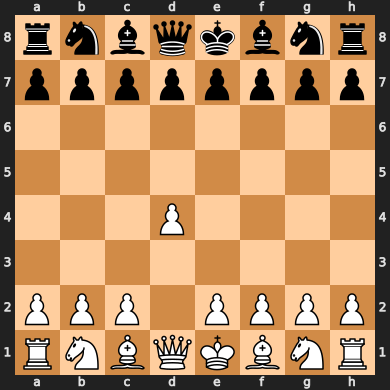

In [11]:
import sys
import chess
sys.path.insert(1, 'Classes/')
from dataset_utils import encodeBoard
from ScoreGetter import ScoreGetter

score_getter = ScoreGetter('/home/gaetan/Téléchargements/stockfish/stockfish', 'eval', 'go depth 1')

df = pd.read_csv('Datasets/raw_dataset_13M.csv', nrows=1000)
fens = df['board'].values

fen = 'rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1'#fens[np.random.randint(fens.shape[0])]
print(fen)
e = np.array(encodeBoard(fen)).reshape(1, -1)
print(f'stockfish score: {score_getter.getScore(fen)}')
print(f'pred score: {int(model.predict(e).flatten()[0])}')

chess.Board(fen)

In [12]:
model.save('../model', save_format='tf')

INFO:tensorflow:Assets written to: ../model/assets
